In [88]:
import json
from collections import defaultdict
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [89]:
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

In [90]:
file_path = 'dataset.json'

with open(file_path, 'r') as data:
    tx_data = json.load(data)

    if tx_data:
        print(json.dumps(tx_data[0], indent=2))

{
  "_id": {
    "$oid": "681d38fed63812d4655f571a"
  },
  "userWallet": "0x00000000001accfa9cef68cf5371a23025b6d4b6",
  "network": "polygon",
  "protocol": "aave_v2",
  "txHash": "0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6d2e66e6b0e3b2e8d4190",
  "logId": "0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6d2e66e6b0e3b2e8d4190_Deposit",
  "timestamp": 1629178166,
  "blockNumber": 1629178166,
  "action": "deposit",
  "actionData": {
    "type": "Deposit",
    "amount": "2000000000",
    "assetSymbol": "USDC",
    "assetPriceUSD": "0.9938318274296357543568636362026045",
    "poolId": "0x2791bca1f2de4661ed88a30c99a7a9449aa84174",
    "userId": "0x00000000001accfa9cef68cf5371a23025b6d4b6"
  },
  "__v": 0,
  "createdAt": {
    "$date": "2025-05-08T23:06:39.465Z"
  },
  "updatedAt": {
    "$date": "2025-05-08T23:06:39.465Z"
  }
}


In [91]:
len(tx_data)

100000

In [92]:
wallet_features = defaultdict(lambda: {
        'total_transactions': 0,
        'protocols': set(),
        'assets': set(),
        'total_deposits': 0,
        'total_withdrawals': 0,
        'borrowed': 0,
        'repaid': 0,
        'liquidations': 0,
        'tx_amounts': [],
        'timestamps': [],
        'actions': [],
        'gas_fees': [],
        'hourly_distribution': defaultdict(int),
        'daily_distribution': defaultdict(int),
        'failed_txs': 0
    })

In [93]:
for i, tx in enumerate(tx_data):
    if i % 10000 == 0:
        print(f"Processed {i} transactions...")
        
    w = tx['userWallet']
    wallet_features[w]['total_transactions'] += 1
    wallet_features[w]['protocols'].add(tx['protocol'])
    wallet_features[w]['timestamps'].append(tx['timestamp'])
    
    action = tx['action'].lower()
    wallet_features[w]['actions'].append(action)
    
    amount = float(tx['actionData'].get('amount', '0'))
    asset = tx['actionData'].get('assetSymbol', 'unknown')
    price_usd = float(tx['actionData'].get('assetPriceUSD', '1'))
    amount_usd = amount * price_usd
    
    # Gas fee (if available)
    gas_fee = float(tx.get('gasFee', '0'))
    wallet_features[w]['gas_fees'].append(gas_fee)
    
    # Transaction success (if available)
    if tx.get('status') == 'failed':
        wallet_features[w]['failed_txs'] += 1
    
    wallet_features[w]['assets'].add(asset)
    wallet_features[w]['tx_amounts'].append(amount_usd)
    
    # Time-based features
    dt = datetime.fromtimestamp(tx['timestamp'])
    wallet_features[w]['hourly_distribution'][dt.hour] += 1
    wallet_features[w]['daily_distribution'][dt.weekday()] += 1
    
    # Action-specific processing
    if action == 'deposit':
        wallet_features[w]['total_deposits'] += amount_usd
    elif action in ['withdraw', 'redeemunderlying']:
        wallet_features[w]['total_withdrawals'] += amount_usd
    elif action == 'borrow':
        wallet_features[w]['borrowed'] += amount_usd
    elif action == 'repay':
        wallet_features[w]['repaid'] += amount_usd
    elif action == 'liquidationcall':
        wallet_features[w]['liquidations'] += 1

print(f"Aggregated features for {len(wallet_features)} unique wallets")


Processed 0 transactions...
Processed 10000 transactions...
Processed 20000 transactions...
Processed 30000 transactions...
Processed 40000 transactions...
Processed 50000 transactions...
Processed 60000 transactions...
Processed 70000 transactions...
Processed 80000 transactions...
Processed 90000 transactions...
Aggregated features for 3497 unique wallets


In [94]:
wallet_features[0]

{'total_transactions': 0,
 'protocols': set(),
 'assets': set(),
 'total_deposits': 0,
 'total_withdrawals': 0,
 'borrowed': 0,
 'repaid': 0,
 'liquidations': 0,
 'tx_amounts': [],
 'timestamps': [],
 'actions': [],
 'gas_fees': [],
 'hourly_distribution': defaultdict(int, {}),
 'daily_distribution': defaultdict(int, {}),
 'failed_txs': 0}

In [95]:
def calculate_entropy(distribution):
    """Calculate entropy for time distribution (bot detection)"""
    if not distribution or sum(distribution) == 0:
        return 0
    
    total = sum(distribution)
    probs = [x / total for x in distribution if x > 0]
    return -sum(p * np.log2(p) for p in probs)

In [96]:
def convert_to_dataframe(wallet_features):
    """Convert wallet features to DataFrame with engineered features"""
    rows = []
    
    print("Converting to DataFrame and engineering features...")
    for i, (w, f) in enumerate(wallet_features.items()):
        if i % 1000 == 0:
            print(f"Processed {i} wallets...")
            
        # --- Time-based features ---
        timestamps = sorted(f['timestamps'])
        active_days = len(set(pd.to_datetime(timestamps, unit='s').date))
        
        if len(timestamps) > 1:
            time_diffs = [(timestamps[j+1] - timestamps[j]) for j in range(len(timestamps)-1)]
            avg_time_diff = sum(time_diffs) / len(time_diffs)
            std_time_diff = np.std(time_diffs)
            activity_span = timestamps[-1] - timestamps[0]
        else:
            avg_time_diff = 0
            std_time_diff = 0
            activity_span = 0
        
        # --- Transaction amount statistics ---
        tx_amounts = f['tx_amounts']
        if tx_amounts:
            avg_tx_amount    = np.mean(tx_amounts)
            std_tx_amount    = np.std(tx_amounts)
            median_tx_amount = np.median(tx_amounts)
            max_tx_amount    = max(tx_amounts)
            min_tx_amount    = min(tx_amounts)
        else:
            avg_tx_amount = std_tx_amount = median_tx_amount = 0
            max_tx_amount = min_tx_amount = 0
        
        # --- Behavioral patterns (fixed zero-division) ---
        actions = f.get('actions', [])
        action_counts = pd.Series(actions).value_counts()
        num_actions = len(actions)
        
        if num_actions > 0:
            deposit_ratio     = action_counts.get('deposit', 0)         / num_actions
            borrow_ratio      = action_counts.get('borrow', 0)          / num_actions
            repay_ratio       = action_counts.get('repay', 0)           / num_actions
            liquidation_ratio = action_counts.get('liquidationcall', 0) / num_actions
        else:
            deposit_ratio = borrow_ratio = repay_ratio = liquidation_ratio = 0
        
        # --- Financial health indicators ---
        total_deposits    = f['total_deposits']
        total_withdrawals = f['total_withdrawals']
        total_borrowed    = f['borrowed']
        total_repaid      = f['repaid']
        
        net_flow          = total_deposits - total_withdrawals
        utilization_ratio = total_borrowed / max(total_deposits, 1)
        repayment_ratio   = total_repaid   / max(total_borrowed, 1)
        
        # --- Risk indicators ---
        failed_tx_ratio = f['failed_txs'] / max(f['total_transactions'], 1)
        avg_gas_fee     = np.mean(f['gas_fees']) if f['gas_fees'] else 0
        
        # --- Time distribution features (bot detection) ---
        hourly_entropy = calculate_entropy(list(f['hourly_distribution'].values()))
        daily_entropy  = calculate_entropy(list(f['daily_distribution'].values()))
        
        # --- Activity consistency ---
        tx_frequency        = f['total_transactions'] / max(active_days, 1)
        activity_consistency = (
            active_days / (activity_span / 86400)
            if activity_span > 0 else 0
        )
        
        # --- Assemble row ---
        row = {
            'wallet': w,
            'total_transactions': f['total_transactions'],
            'num_protocols': len(f['protocols']),
            'num_assets': len(f['assets']),
            'active_days': active_days,
            'activity_span_days': activity_span / 86400,
            'tx_frequency': tx_frequency,
            'activity_consistency': activity_consistency,
            
            # Financial features
            'total_deposits_usd': total_deposits,
            'total_withdrawals_usd': total_withdrawals,
            'net_flow_usd': net_flow,
            'total_borrowed_usd': total_borrowed,
            'total_repaid_usd': total_repaid,
            'utilization_ratio': utilization_ratio,
            'repayment_ratio': repayment_ratio,
            
            # Transaction patterns
            'avg_tx_amount_usd': avg_tx_amount,
            'std_tx_amount_usd': std_tx_amount,
            'median_tx_amount_usd': median_tx_amount,
            'max_tx_amount_usd': max_tx_amount,
            'min_tx_amount_usd': min_tx_amount,
            'avg_time_between_txs': avg_time_diff,
            'std_time_between_txs': std_time_diff,
            
            # Behavioral ratios
            'deposit_ratio': deposit_ratio,
            'borrow_ratio': borrow_ratio,
            'repay_ratio': repay_ratio,
            'liquidation_ratio': liquidation_ratio,
            'liquidation_count': f['liquidations'],
            
            # Risk indicators
            'failed_tx_ratio': failed_tx_ratio,
            'avg_gas_fee': avg_gas_fee,
            'hourly_entropy': hourly_entropy,
            'daily_entropy': daily_entropy,
        }
        rows.append(row)
    
    return pd.DataFrame(rows)

df = convert_to_dataframe(wallet_features)


Converting to DataFrame and engineering features...
Processed 0 wallets...
Processed 1000 wallets...
Processed 2000 wallets...
Processed 3000 wallets...


In [97]:
df

,wallet,total_transactions,num_protocols,num_assets,active_days,activity_span_days,tx_frequency,activity_consistency,total_deposits_usd,total_withdrawals_usd,...,std_time_between_txs,deposit_ratio,borrow_ratio,repay_ratio,liquidation_ratio,liquidation_count,failed_tx_ratio,avg_gas_fee,hourly_entropy,daily_entropy
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,1,1,1,1,0.000000,1.000000,0.000000,1.987664e+09,0.000000e+00,...,0.000000e+00,1.000000,0.000000,0.000000,0.0,0,0.0,0.0,-0.000000,-0.000000
1,0x000000000051d07a4fb3bd10121a343d85818da6,1,1,1,1,0.000000,1.000000,0.000000,2.856945e+20,0.000000e+00,...,0.000000e+00,1.000000,0.000000,0.000000,0.0,0,0.0,0.0,-0.000000,-0.000000
2,0x000000000096026fb41fc39f9875d164bd82e2dc,2,1,1,2,7.574132,1.000000,0.264057,5.152311e+15,0.000000e+00,...,0.000000e+00,1.000000,0.000000,0.000000,0.0,0,0.0,0.0,1.000000,1.000000
3,0x0000000000e189dd664b9ab08a33c4839953852c,17,1,4,8,129.327766,2.125000,0.061858,0.000000e+00,9.803600e+20,...,1.680109e+06,0.000000,0.000000,0.000000,0.0,0,0.0,0.0,2.866587,1.903968
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,399,1,6,104,132.865903,3.836538,0.782744,2.065773e+23,1.128745e+23,...,6.154332e+04,0.626566,0.037594,0.010025,0.0,0,0.0,0.0,4.391083,2.782828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3493,0x06189341e523a52ae10c4bd4a7774371fac1b249,7,1,3,1,0.278125,7.000000,3.595506,1.272592e+19,6.089061e+18,...,8.325108e+03,0.571429,0.142857,0.000000,0.0,0,0.0,0.0,1.378783,-0.000000
3494,0x0618c450370822c5cb25ec143a3008230d8e2c12,5,1,4,1,0.010613,5.000000,94.220284,3.530977e+22,4.298987e+22,...,2.551797e+02,0.200000,0.000000,0.000000,0.0,0,0.0,0.0,-0.000000,-0.000000
3495,0x0618e615c8c9b5efc8c8eadc68be7182bdc455e2,22,1,7,11,31.065914,2.000000,0.354086,6.793268e+21,7.926166e+20,...,1.599696e+05,0.590909,0.090909,0.090909,0.0,0,0.0,0.0,3.243300,2.218388
3496,0x06192f889f17bf2aff238d08d8c26cbcfcc7b45a,183,1,7,37,59.558519,4.945946,0.621238,3.287158e+23,2.043952e+23,...,7.341613e+04,0.289617,0.262295,0.196721,0.0,0,0.0,0.0,3.884606,2.656620


In [98]:
df.shape

(3498, 31)

In [99]:
df.head(4)

,wallet,total_transactions,num_protocols,num_assets,active_days,activity_span_days,tx_frequency,activity_consistency,total_deposits_usd,total_withdrawals_usd,...,std_time_between_txs,deposit_ratio,borrow_ratio,repay_ratio,liquidation_ratio,liquidation_count,failed_tx_ratio,avg_gas_fee,hourly_entropy,daily_entropy
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,1,1,1,1,0.000000,1.000,0.000000,1.987664e+09,0.000000e+00,...,0.000000e+00,1.0,0.0,0.0,0.0,0,0.0,0.0,-0.000000,-0.000000
1,0x000000000051d07a4fb3bd10121a343d85818da6,1,1,1,1,0.000000,1.000,0.000000,2.856945e+20,0.000000e+00,...,0.000000e+00,1.0,0.0,0.0,0.0,0,0.0,0.0,-0.000000,-0.000000
2,0x000000000096026fb41fc39f9875d164bd82e2dc,2,1,1,2,7.574132,1.000,0.264057,5.152311e+15,0.000000e+00,...,0.000000e+00,1.0,0.0,0.0,0.0,0,0.0,0.0,1.000000,1.000000
3,0x0000000000e189dd664b9ab08a33c4839953852c,17,1,4,8,129.327766,2.125,0.061858,0.000000e+00,9.803600e+20,...,1.680109e+06,0.0,0.0,0.0,0.0,0,0.0,0.0,2.866587,1.903968


In [100]:
df.describe()

,total_transactions,num_protocols,num_assets,active_days,activity_span_days,tx_frequency,activity_consistency,total_deposits_usd,total_withdrawals_usd,net_flow_usd,...,std_time_between_txs,deposit_ratio,borrow_ratio,repay_ratio,liquidation_ratio,liquidation_count,failed_tx_ratio,avg_gas_fee,hourly_entropy,daily_entropy
count,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3.498000e+03,3.498000e+03,3.498000e+03,...,3.498000e+03,3498.000000,3498.000000,3498.000000,3498.000000,3498.000000,3498.0,3498.0,3498.000000,3498.000000
mean,28.587764,0.999714,2.452258,6.562035,21.867885,2.617308,172.989768,1.204693e+23,9.251375e+22,2.795557e+22,...,2.066614e+05,0.646959,0.124186,0.063298,0.003591,0.070898,0.0,0.0,1.243851,0.910962
std,250.696689,0.016908,1.960762,12.527842,33.327311,4.751391,1052.645075,1.706457e+24,1.452173e+24,6.464840e+23,...,4.285045e+05,0.327885,0.160273,0.107755,0.032562,0.692791,0.0,0.0,1.359850,1.006636
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,-1.263310e+25,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.991101e+09,0.000000e+00,1.097559e+06,...,0.000000e+00,0.376556,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
50%,3.000000,1.000000,2.000000,2.000000,2.900162,1.666667,0.184957,1.934279e+18,0.000000e+00,2.167349e+17,...,1.946796e+01,0.600000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0.811278
75%,16.000000,1.000000,3.000000,5.000000,32.686444,3.000000,0.571069,1.910192e+21,4.141283e+20,2.597582e+20,...,2.180833e+05,1.000000,0.239859,0.111111,0.000000,0.000000,0.0,0.0,2.321928,1.805938
max,14265.000000,1.000000,9.000000,112.000000,153.792407,216.136364,43200.000000,6.056302e+25,6.058051e+25,2.422762e+25,...,4.407294e+06,1.000000,1.000000,0.735849,0.750000,26.000000,0.0,0.0,4.561447,2.801082


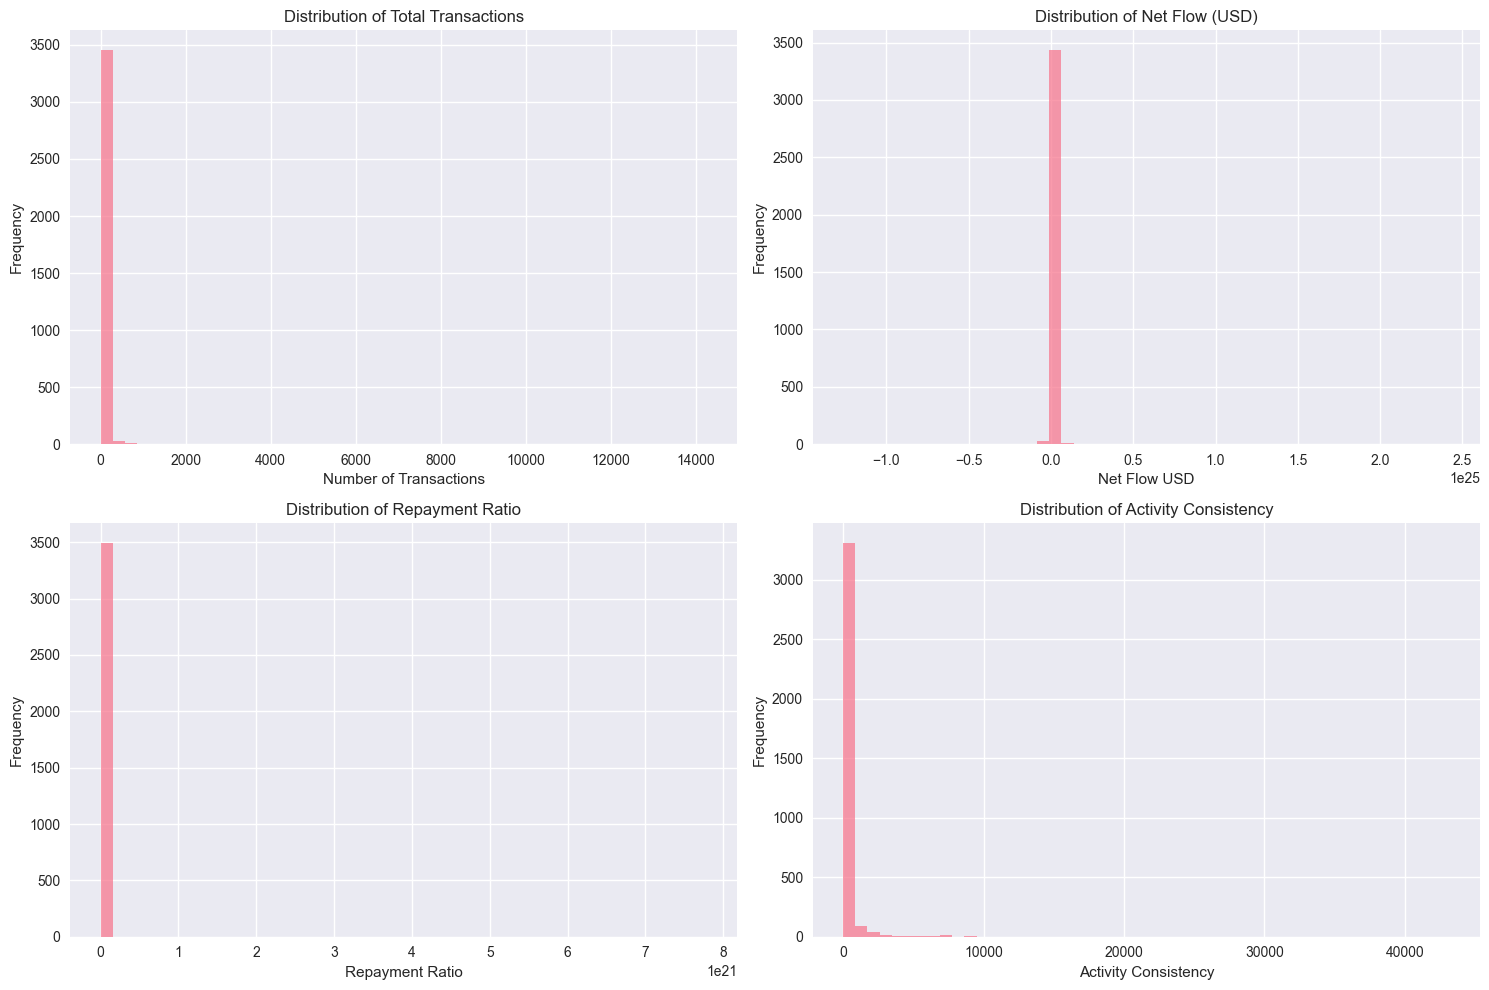

In [101]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Transaction distribution
axes[0,0].hist(df['total_transactions'], bins=50, alpha=0.7)
axes[0,0].set_title('Distribution of Total Transactions')
axes[0,0].set_xlabel('Number of Transactions')
axes[0,0].set_ylabel('Frequency')

# Net flow distribution
axes[0,1].hist(df['net_flow_usd'], bins=50, alpha=0.7)
axes[0,1].set_title('Distribution of Net Flow (USD)')
axes[0,1].set_xlabel('Net Flow USD')
axes[0,1].set_ylabel('Frequency')

# Repayment ratio
axes[1,0].hist(df['repayment_ratio'], bins=50, alpha=0.7)
axes[1,0].set_title('Distribution of Repayment Ratio')
axes[1,0].set_xlabel('Repayment Ratio')
axes[1,0].set_ylabel('Frequency')

# Activity consistency
axes[1,1].hist(df['activity_consistency'], bins=50, alpha=0.7)
axes[1,1].set_title('Distribution of Activity Consistency')
axes[1,1].set_xlabel('Activity Consistency')
axes[1,1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [102]:
def engineer_advanced_features(df):
    """Engineer additional features for credit scoring"""
    df = df.copy()
    
    # Handle missing values
    df = df.fillna(0)
    
    # Composite risk score components
    df['portfolio_diversity'] = df['num_assets'] * df['num_protocols']
    df['volume_consistency'] = df['std_tx_amount_usd'] / (df['avg_tx_amount_usd'] + 1)
    df['financial_stability'] = (df['repayment_ratio'] + 1) / (df['utilization_ratio'] + 1)
    df['activity_maturity'] = df['activity_span_days'] * df['activity_consistency']
    
    # Risk flags
    df['high_liquidation_risk'] = (df['liquidation_ratio'] > 0.1).astype(int)
    df['bot_like_behavior'] = ((df['hourly_entropy'] < 2) & (df['daily_entropy'] < 2)).astype(int)
    df['whale_behavior'] = (df['max_tx_amount_usd'] > df['max_tx_amount_usd'].quantile(0.95)).astype(int)
    
    # Interaction features
    df['deposit_to_borrow_ratio'] = df['total_deposits_usd'] / (df['total_borrowed_usd'] + 1)
    df['net_flow_ratio'] = df['net_flow_usd'] / (df['total_deposits_usd'] + 1)
    
    return df

# Engineer advanced features
df_engineered = engineer_advanced_features(df)

In [103]:
df_engineered

,wallet,total_transactions,num_protocols,num_assets,active_days,activity_span_days,tx_frequency,activity_consistency,total_deposits_usd,total_withdrawals_usd,...,daily_entropy,portfolio_diversity,volume_consistency,financial_stability,activity_maturity,high_liquidation_risk,bot_like_behavior,whale_behavior,deposit_to_borrow_ratio,net_flow_ratio
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,1,1,1,1,0.000000,1.000000,0.000000,1.987664e+09,0.000000e+00,...,-0.000000,1,0.000000,1.000000,0.0,0,1,0,1.987664e+09,1.000000e+00
1,0x000000000051d07a4fb3bd10121a343d85818da6,1,1,1,1,0.000000,1.000000,0.000000,2.856945e+20,0.000000e+00,...,-0.000000,1,0.000000,1.000000,0.0,0,1,0,2.856945e+20,1.000000e+00
2,0x000000000096026fb41fc39f9875d164bd82e2dc,2,1,1,2,7.574132,1.000000,0.264057,5.152311e+15,0.000000e+00,...,1.000000,1,0.641956,1.000000,2.0,0,1,0,5.152311e+15,1.000000e+00
3,0x0000000000e189dd664b9ab08a33c4839953852c,17,1,4,8,129.327766,2.125000,0.061858,0.000000e+00,9.803600e+20,...,1.903968,4,2.568949,1.000000,8.0,0,0,0,0.000000e+00,-9.803600e+20
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,399,1,6,104,132.865903,3.836538,0.782744,2.065773e+23,1.128745e+23,...,2.782828,6,3.526152,0.774060,104.0,0,0,0,3.425962e+00,4.535968e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3493,0x06189341e523a52ae10c4bd4a7774371fac1b249,7,1,3,1,0.278125,7.000000,3.595506,1.272592e+19,6.089061e+18,...,-0.000000,3,0.799136,0.845202,1.0,0,1,0,5.460044e+00,5.215229e-01
3494,0x0618c450370822c5cb25ec143a3008230d8e2c12,5,1,4,1,0.010613,5.000000,94.220284,3.530977e+22,4.298987e+22,...,-0.000000,4,1.051661,1.000000,1.0,0,1,0,3.530977e+22,-2.175065e-01
3495,0x0618e615c8c9b5efc8c8eadc68be7182bdc455e2,22,1,7,11,31.065914,2.000000,0.354086,6.793268e+21,7.926166e+20,...,2.218388,7,2.633270,1.166273,11.0,0,0,0,5.650613e+12,8.833232e-01
3496,0x06192f889f17bf2aff238d08d8c26cbcfcc7b45a,183,1,7,37,59.558519,4.945946,0.621238,3.287158e+23,2.043952e+23,...,2.656620,7,2.381040,0.774375,37.0,0,0,1,1.208611e+00,3.782008e-01


In [104]:
def create_credit_score_target(df):
    """Create synthetic credit score target for training"""
    df = df.copy()
    base_score = 500  # Start with neutral score
    
    # Positive factors
    df['score'] = base_score
    df['score'] += df['repayment_ratio'] * 200  # Good repayment history
    df['score'] += np.log1p(df['activity_span_days']) * 10  # Longer history
    df['score'] += df['portfolio_diversity'] * 5  # Diversification
    df['score'] += df['activity_consistency'] * 100  # Consistent usage
    df['score'] += (df['hourly_entropy'] + df['daily_entropy']) * 20  # Natural patterns
    
    # Negative factors
    df['score'] -= df['liquidation_count'] * 50  # Liquidations are bad
    df['score'] -= df['failed_tx_ratio'] * 200  # Failed transactions
    df['score'] -= df['bot_like_behavior'] * 150  # Bot-like behavior
    df['score'] -= (df['volume_consistency'] > 2) * 100  # Erratic behavior
    df['score'] -= (df['utilization_ratio'] > 0.8) * 100  # Over-leveraged
    
    # Ensure score is between 0 and 1000
    df['score'] = np.clip(df['score'], 0, 1000)
    
    return df


df_with_scores = create_credit_score_target(df_engineered)

In [105]:
df_with_scores

,wallet,total_transactions,num_protocols,num_assets,active_days,activity_span_days,tx_frequency,activity_consistency,total_deposits_usd,total_withdrawals_usd,...,portfolio_diversity,volume_consistency,financial_stability,activity_maturity,high_liquidation_risk,bot_like_behavior,whale_behavior,deposit_to_borrow_ratio,net_flow_ratio,score
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,1,1,1,1,0.000000,1.000000,0.000000,1.987664e+09,0.000000e+00,...,1,0.000000,1.000000,0.0,0,1,0,1.987664e+09,1.000000e+00,355.000000
1,0x000000000051d07a4fb3bd10121a343d85818da6,1,1,1,1,0.000000,1.000000,0.000000,2.856945e+20,0.000000e+00,...,1,0.000000,1.000000,0.0,0,1,0,2.856945e+20,1.000000e+00,355.000000
2,0x000000000096026fb41fc39f9875d164bd82e2dc,2,1,1,2,7.574132,1.000000,0.264057,5.152311e+15,0.000000e+00,...,1,0.641956,1.000000,2.0,0,1,0,5.152311e+15,1.000000e+00,442.893164
3,0x0000000000e189dd664b9ab08a33c4839953852c,17,1,4,8,129.327766,2.125000,0.061858,0.000000e+00,9.803600e+20,...,4,2.568949,1.000000,8.0,0,0,0,0.000000e+00,-9.803600e+20,570.297457
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,399,1,6,104,132.865903,3.836538,0.782744,2.065773e+23,1.128745e+23,...,6,3.526152,0.774060,104.0,0,0,0,3.425962e+00,4.535968e-01,700.721014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3493,0x06189341e523a52ae10c4bd4a7774371fac1b249,7,1,3,1,0.278125,7.000000,3.595506,1.272592e+19,6.089061e+18,...,3,0.799136,0.845202,1.0,0,1,0,5.460044e+00,5.215229e-01,754.580173
3494,0x0618c450370822c5cb25ec143a3008230d8e2c12,5,1,4,1,0.010613,5.000000,94.220284,3.530977e+22,4.298987e+22,...,4,1.051661,1.000000,1.0,0,1,0,3.530977e+22,-2.175065e-01,1000.000000
3495,0x0618e615c8c9b5efc8c8eadc68be7182bdc455e2,22,1,7,11,31.065914,2.000000,0.354086,6.793268e+21,7.926166e+20,...,7,2.633270,1.166273,11.0,0,0,0,5.650613e+12,8.833232e-01,647.574840
3496,0x06192f889f17bf2aff238d08d8c26cbcfcc7b45a,183,1,7,37,59.558519,4.945946,0.621238,3.287158e+23,2.043952e+23,...,7,2.381040,0.774375,37.0,0,0,1,1.208611e+00,3.782008e-01,652.002483


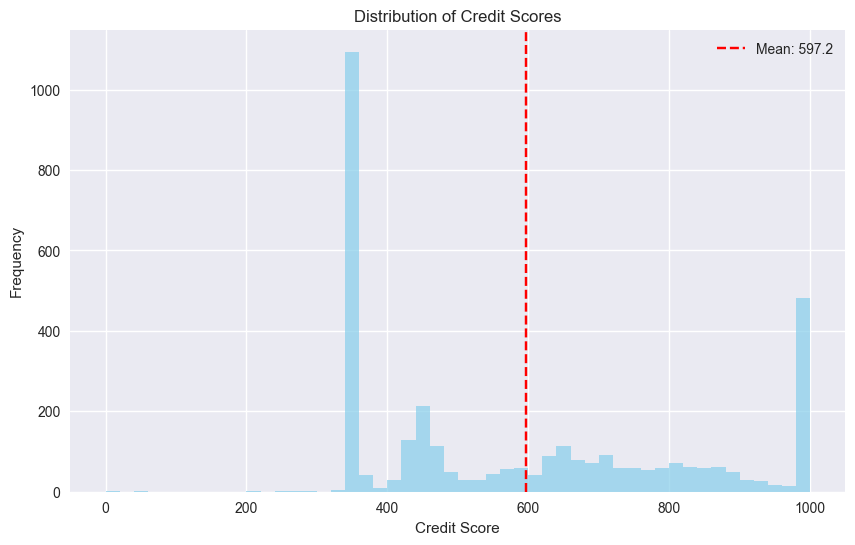

In [106]:
plt.figure(figsize=(10, 6))
plt.hist(df_with_scores['score'], bins=50, alpha=0.7, color='skyblue')
plt.title('Distribution of Credit Scores')
plt.xlabel('Credit Score')
plt.ylabel('Frequency')
plt.axvline(df_with_scores['score'].mean(), color='red', linestyle='--', 
            label=f'Mean: {df_with_scores["score"].mean():.1f}')
plt.legend()
plt.show()


In [107]:
print(df_with_scores['score'].describe())

count    3498.000000
mean      597.214622
std       237.425684
min         0.000000
25%       355.000000
50%       539.400603
75%       799.607935
max      1000.000000
Name: score, dtype: float64


In [108]:
feature_cols = [col for col in df_with_scores.columns if col not in ['wallet', 'score']]
X = df_with_scores[feature_cols]
y = df_with_scores['score']


In [109]:
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

In [110]:
print(f"Feature matrix shape: {X.shape}, Target vector shape: {y.shape}")

Feature matrix shape: (3498, 39), Target vector shape: (3498,)


In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [112]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  
X_test_scaled = scaler.transform(X_test)

In [113]:
print(f"training set shape: {X_train_scaled.shape}, test set shape: {X_test_scaled.shape}")

training set shape: (2798, 39), test set shape: (700, 39)


In [114]:
gb_model = GradientBoostingRegressor(

    n_estimators=100,
    learning_rate=0.1, 
    max_depth=6,
    random_state=42

)

In [115]:
gb_model.fit(X_train_scaled, y_train)

,loss,'squared_error'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,6
,min_impurity_decrease,0.0
,init,None


In [116]:
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42
)

In [117]:
rf_model.fit(X_train_scaled, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [118]:
gb_pred = gb_model.predict(X_test_scaled)
rf_pred = rf_model.predict(X_test_scaled)

In [119]:
gb_mse = mean_squared_error(y_test, gb_pred)
gb_r2 = r2_score(y_test, gb_pred)

In [120]:
rf_mse = mean_squared_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)

In [121]:
print(f"Gradient Boosting - MSE: {gb_mse:.2f}, R²: {gb_r2:.3f}, RMSE: {np.sqrt(gb_mse):.2f}")
print(f"Random Forest - MSE: {rf_mse:.2f}, R²: {rf_r2:.3f}, RMSE: {np.sqrt(rf_mse):.2f}")

Gradient Boosting - MSE: 1473.44, R²: 0.974, RMSE: 38.39
Random Forest - MSE: 1991.87, R²: 0.965, RMSE: 44.63


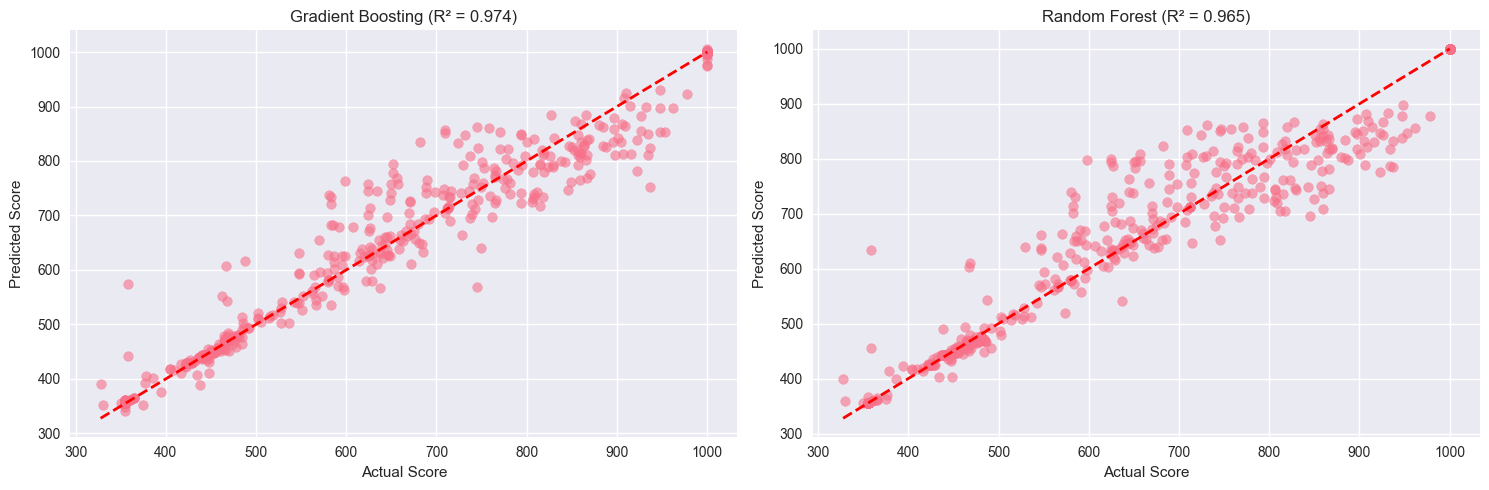

In [122]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gradient Boosting
axes[0].scatter(y_test, gb_pred, alpha=0.6)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Score')
axes[0].set_ylabel('Predicted Score')
axes[0].set_title(f'Gradient Boosting (R² = {gb_r2:.3f})')

# Random Forest
axes[1].scatter(y_test, rf_pred, alpha=0.6)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Score')
axes[1].set_ylabel('Predicted Score')
axes[1].set_title(f'Random Forest (R² = {rf_r2:.3f})')

plt.tight_layout()
plt.show()

In [123]:
best_model = gb_model
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 15 Most Important Features:")
print(feature_importance.head(15))

Top 15 Most Important Features:
                  feature  importance
5            tx_frequency    0.516072
6    activity_consistency    0.256584
23            repay_ratio    0.062654
35      bot_like_behavior    0.048988
28         hourly_entropy    0.018835
31     volume_consistency    0.015517
19   avg_time_between_txs    0.013880
29          daily_entropy    0.012215
24      liquidation_ratio    0.011676
25      liquidation_count    0.008641
10     total_borrowed_usd    0.007570
4      activity_span_days    0.005613
11       total_repaid_usd    0.005144
22           borrow_ratio    0.003731
8   total_withdrawals_usd    0.002727


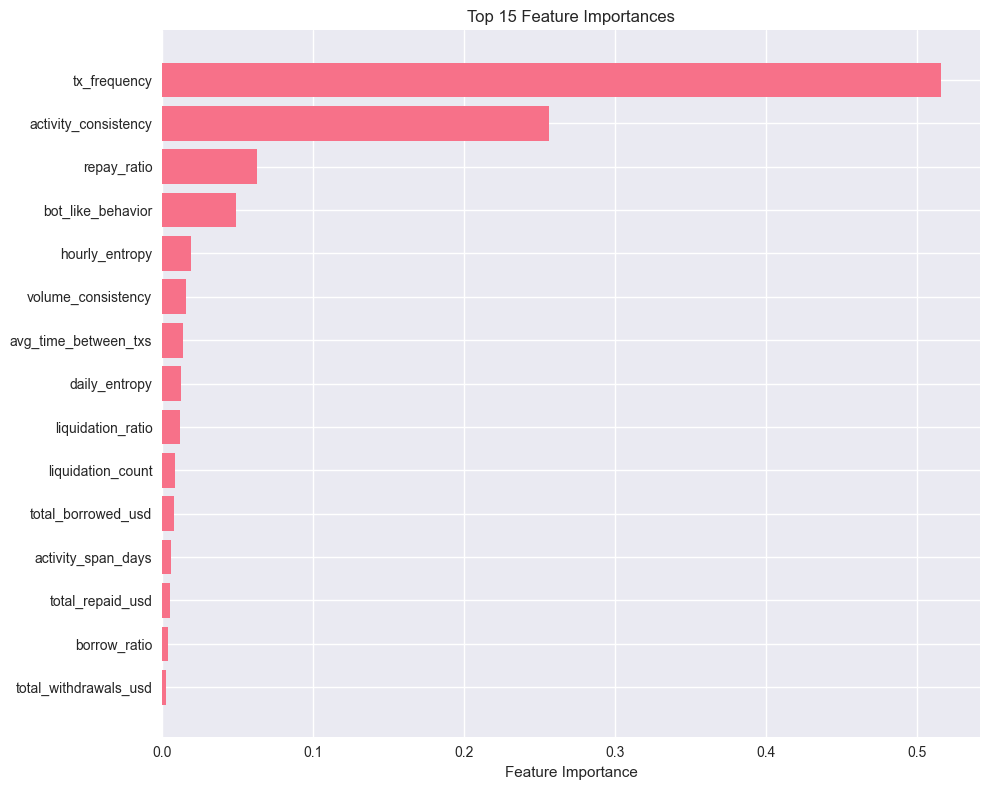

In [124]:
# Visualize feature importance
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [125]:
def generate_credit_scores(model, scaler, feature_cols, df_original):
    """Generate final credit scores for all wallets"""
    
    # Prepare features
    df_processed = engineer_advanced_features(df_original)
    X = df_processed[feature_cols]
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_scaled = scaler.transform(X)
    
    # Predict scores
    scores = model.predict(X_scaled)
    scores = np.clip(scores, 0, 1000)  # Ensure scores are in valid range
    
    # Create results dataframe
    results = pd.DataFrame({
        'wallet': df_processed['wallet'],
        'credit_score': scores.round(0).astype(int)
    })
    
    return results.sort_values('credit_score', ascending=False)

# Generate final credit scores
final_scores = generate_credit_scores(best_model, scaler, feature_cols, df)


In [126]:
print(f"Generated credit scores for {len(final_scores)} wallets")
print(f"\nCredit Score Distribution:")
print(final_scores['credit_score'].describe())

print(f"\nTop 10 Highest Credit Scores:")
print(final_scores.head(10))

print(f"\nBottom 10 Lowest Credit Scores:")
print(final_scores.tail(10))

Generated credit scores for 3498 wallets

Credit Score Distribution:
count    3498.000000
mean      597.284734
std       235.509415
min         0.000000
25%       355.000000
50%       542.500000
75%       795.750000
max      1000.000000
Name: credit_score, dtype: float64

Top 10 Highest Credit Scores:
                                          wallet  credit_score
1735  0x02eda208efc7d92efeaf7418833c3081a42dd3a1          1000
3468  0x060c5955567657dbc9c2374e4647bf9d10c011ac          1000
1732  0x02ebdd4d10b91e3018c0706a39a02c5fe1c893ef          1000
1022  0x01ac60352b386d551222c877925f524d43725149          1000
2488  0x0450d81146ae1eb15d886b0a35673dbb9e74be19          1000
42    0x000c8e2871750f458bf1de8ab528dda09bc95db6          1000
57    0x0011730224657eb527cf736039854c3a3f140e63          1000
58    0x00120ea6fdbaf057eadc1bd149f957488444e92c          1000
2492  0x0452d528c990273208cd331b2c14de884354ea5b          1000
471   0x00b65668a962ee571a8f223abd696ab1bd3a391f          1000

Bot

In [127]:
def analyze_risk_segments(scores_df, features_df):
    """Analyze different risk segments"""
    
    # Merge scores with features
    merged_df = scores_df.merge(features_df, on='wallet')
    
    # Define risk segments
    def risk_category(score):
        if score >= 800:
            return 'Excellent (800-1000)'
        elif score >= 600:
            return 'Good (600-799)'
        elif score >= 400:
            return 'Fair (400-599)'
        elif score >= 200:
            return 'Poor (200-399)'
        else:
            return 'Very Poor (0-199)'
    
    merged_df['risk_category'] = merged_df['credit_score'].apply(risk_category)
    
    # Risk segment analysis
    risk_analysis = merged_df.groupby('risk_category').agg({
        'credit_score': ['count', 'mean'],
        'total_transactions': 'mean',
        'repayment_ratio': 'mean',
        'liquidation_count': 'mean',
        'utilization_ratio': 'mean',
        'activity_consistency': 'mean'
    }).round(2)
    
    return risk_analysis, merged_df

# Perform risk analysis
risk_analysis, merged_scores = analyze_risk_segments(final_scores, df_engineered)

print("Risk Segment Analysis:")
print(risk_analysis)

Risk Segment Analysis:
                     credit_score         total_transactions repayment_ratio  \
                            count    mean               mean            mean   
risk_category                                                                  
Excellent (800-1000)          858  935.73              41.73    9.083284e+18   
Fair (400-599)                736  479.49               7.89    5.000000e-02   
Good (600-799)                752  698.59              74.79    4.700000e-01   
Poor (200-399)               1149  355.21               1.44    0.000000e+00   
Very Poor (0-199)               3   19.00             164.00    3.400000e-01   

                     liquidation_count utilization_ratio activity_consistency  
                                  mean              mean                 mean  
risk_category                                                                  
Excellent (800-1000)              0.01      3.083817e+20               704.55  
Fair (400-599)  

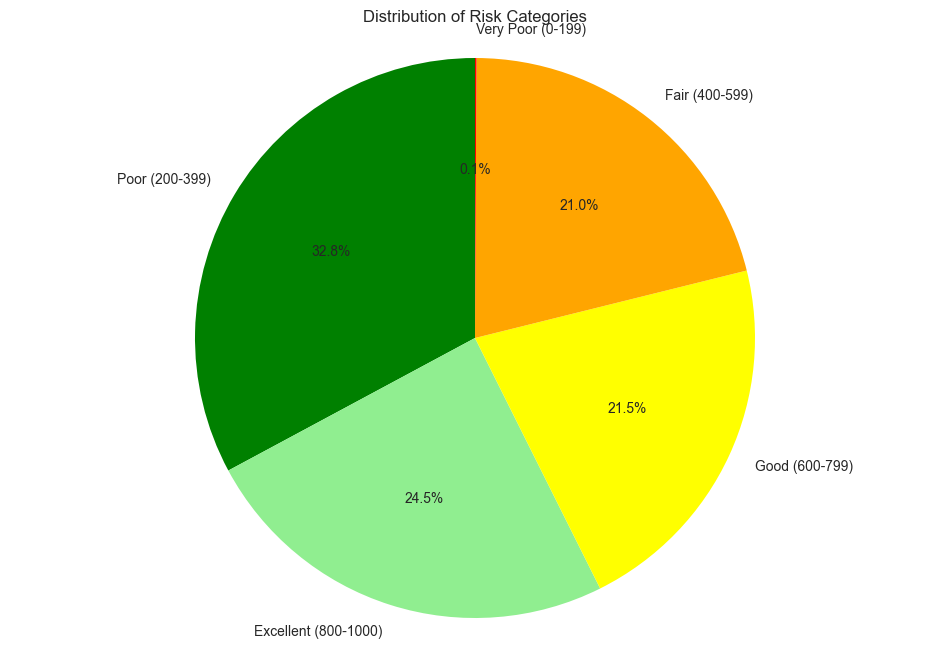

In [128]:
plt.figure(figsize=(12, 8))
risk_counts = merged_scores['risk_category'].value_counts()
colors = ['green', 'lightgreen', 'yellow', 'orange', 'red']
plt.pie(risk_counts.values, labels=risk_counts.index, autopct='%1.1f%%', 
        colors=colors, startangle=90)
plt.title('Distribution of Risk Categories')
plt.axis('equal')
plt.show()

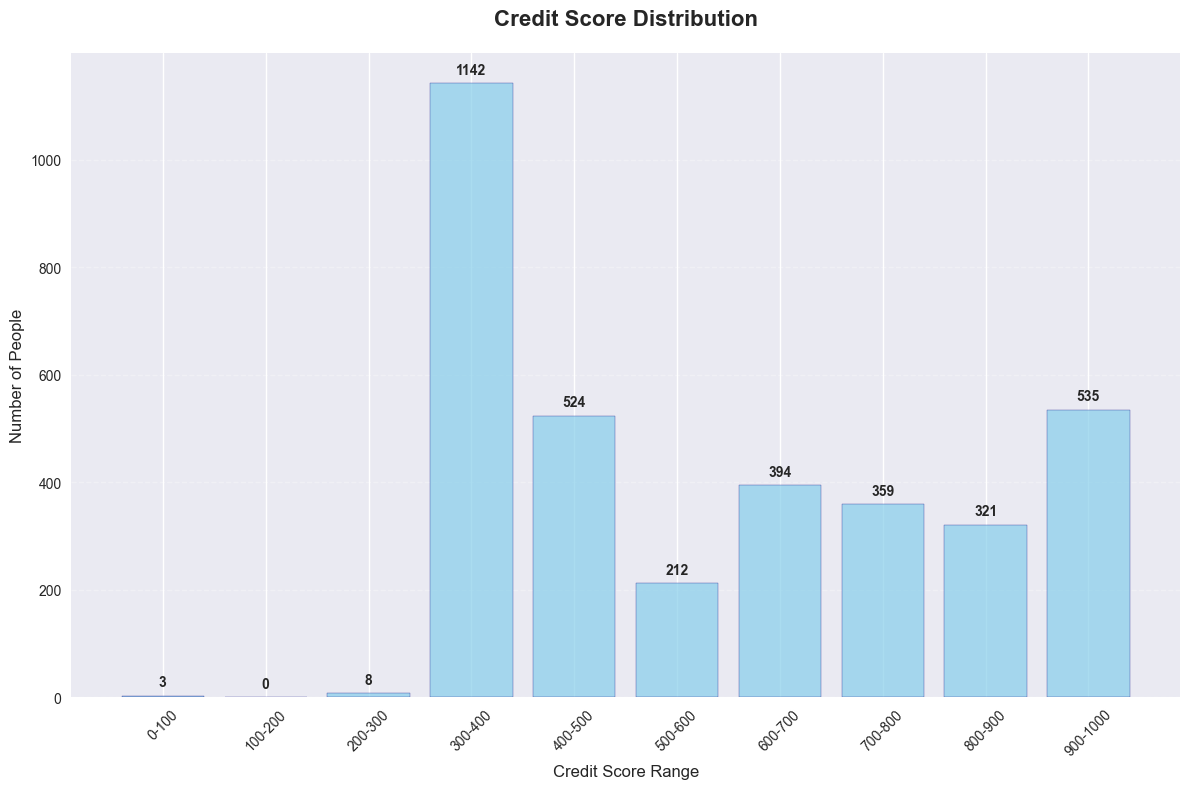


Credit Score Distribution Summary:
0-100: 3 people (0.1%)
100-200: 0 people (0.0%)
200-300: 8 people (0.2%)
300-400: 1142 people (32.6%)
400-500: 524 people (15.0%)
500-600: 212 people (6.1%)
600-700: 394 people (11.3%)
700-800: 359 people (10.3%)
800-900: 321 people (9.2%)
900-1000: 535 people (15.3%)

Total records: 3498
Mean credit score: 597.3
Median credit score: 542.5
Standard deviation: 235.5


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

plt.figure(figsize=(12, 8))

# Define score ranges and bins
score_ranges = ['0-100', '100-200', '200-300', '300-400', '400-500',
                '500-600', '600-700', '700-800', '800-900', '900-1000']
bins = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

# Create score range categories
final_scores['score_range'] = pd.cut(final_scores['credit_score'], 
                                   bins=bins, 
                                   labels=score_ranges, 
                                   include_lowest=True)

# Get distribution counts
distribution = final_scores['score_range'].value_counts().sort_index()

# Create the bar plot
bars = plt.bar(range(len(distribution)), distribution.values, 
               color='skyblue', edgecolor='navy', alpha=0.7)

# Customize the plot
plt.title('Credit Score Distribution', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Credit Score Range', fontsize=12)
plt.ylabel('Number of People', fontsize=12)
plt.xticks(range(len(distribution)), distribution.index, rotation=45)

for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + max(distribution.values)*0.01,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')

plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()


In [129]:
final_scores.to_csv('wallet_credit_scores.csv', index=False)
print("Credit scores saved to 'wallet_credit_scores.csv'")

# Save detailed analysis
merged_scores.to_csv('detailed_wallet_analysis.csv', index=False)
print("Detailed analysis saved to 'detailed_wallet_analysis.csv'")

# Save feature importance
feature_importance.to_csv('feature_importance.csv', index=False)
print("Feature importance saved to 'feature_importance.csv'")

print(f"Best model: Gradient Boosting (R² = {gb_r2:.3f})")

Credit scores saved to 'wallet_credit_scores.csv'
Detailed analysis saved to 'detailed_wallet_analysis.csv'
Feature importance saved to 'feature_importance.csv'
Best model: Gradient Boosting (R² = 0.974)
